# BAL Spectra analysis
In this notebook, Spectra factors are compared between RPRA and healthy subjects as follows:

1. For each cell type, subjects are filtered using the same criteria as during DGE analysis.
2. For each subject and each cell type, the mean cell score for each factor is computed. We refer to this score as the subject score.
2. For each cell type, a Wilcoxon rank sum test is used to test whether the RPRA subject scores are stochastically greater than the healthy subject scores.

In [33]:
import math
import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import anndata
import pickle
import csv
import concurrent.futures
from scipy.stats import spearmanr, mannwhitneyu, wilcoxon, permutation_test
from scipy.cluster.hierarchy import dendrogram, linkage
from statsmodels.stats.multitest import fdrcorrection
from collections import Counter
from itertools import groupby
from matplotlib import gridspec

import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

## Read in data

In [34]:
data_dir = "/projects/b1038/Pulmonary/cpuritz/PASC/data"

In [35]:
adata = sc.read_h5ad(f"{data_dir}/01BAL/integrated_BAL/integrated_BAL.h5ad")

In [36]:
# Remove epithelial cells and SARS-CoV-2
adata = adata[~adata.obs.cell_type.isin(["Epithelial cells", "SARS-CoV-2"])].copy()
adata.obs.cell_type = adata.obs.cell_type.cat.remove_unused_categories()

In [37]:
cell_types = adata.obs.cell_type.cat.categories.to_list()

## Compute cell and subject scores

In [38]:
def get_factor_celltypes(adata, obs_key):
    cell_scores_df = pd.DataFrame(adata.obsm['SPECTRA_cell_scores'])
    cell_scores_df['celltype'] = list(adata.obs[obs_key])
    
    global_factors_series = (cell_scores_df.groupby('celltype').mean() != 0).all()
    global_factors = [factor for factor in global_factors_series.index if global_factors_series[factor]]
    specific_cell_scores = (cell_scores_df.groupby('celltype').mean()).T[~global_factors_series].T
    specific_factors = {}
    
    for i in set(cell_scores_df['celltype']):
        specific_factors[i] = [factor for factor in specific_cell_scores.loc[i].index if
                               specific_cell_scores.loc[i, factor]]
    
    factors_inv = {}
    for i,v in specific_factors.items():
        for factor in v:
            factors_inv[factor] = i
    
    for factor in global_factors:
        factors_inv[factor] = 'global'
            
    return factors_inv

In [39]:
factor_celltypes = get_factor_celltypes(adata, 'cell_type_spectra')

# Obtain gene weights
gene_weights = pd.DataFrame(
    adata.uns['SPECTRA_factors'], 
    index = [f"{factor_celltypes[x]}_{x}" for x in range(adata.uns['SPECTRA_factors'].shape[0])],
    columns = adata.var[adata.var['spectra_vocab']].index
).T

# Obtain cell scores
cell_scores = pd.DataFrame(
    adata.obsm['SPECTRA_cell_scores'], 
    index = adata.obs_names,
    columns = [f"{factor_celltypes[x]}_{x}" for x in range(adata.uns['SPECTRA_factors'].shape[0])]
)

# Map pathway names to factor names
with open(f"{data_dir}/01BAL/spectra/orig_factor_names_map.pkl", 'rb') as f:
    orig_factor_names_map = pickle.load(f)
factor_names_map = {k: ''.join(v.split('_')[:2]) for k, v in orig_factor_names_map.items()}
gene_weights.columns = pd.Index([factor_names_map[x] for x in gene_weights.columns])
cell_scores.columns = pd.Index([factor_names_map[x] for x in cell_scores.columns])

In [40]:
# Add metadata to cell scores
cell_scores["Status"] = adata.obs.is_RPRA.astype(str).map({'True': 'RPRA', 'False': 'Healthy'})
cell_scores["Study_ID"] = adata.obs.Study_ID.astype(str)
cell_scores["cell_type"] = adata.obs.cell_type.astype(str)

In [41]:
# Compute subject scores as mean cell score
subject_scores = cell_scores.groupby(['Study_ID', 'cell_type', 'Status']).agg(['mean', 'count']).reset_index()

# Record number of cells for each subject/cell type combination
count_cols = subject_scores.columns.get_level_values(1) == 'count'
counts = subject_scores.iloc[:, count_cols].iloc[:, [0]].droplevel(1, axis = 1)
subject_scores = subject_scores.iloc[:, ~count_cols].droplevel(1, axis = 1)
subject_scores.insert(3, 'n_cell', counts)

## RPRA vs. Healthy
The question we ask here is: in a given cell type, which factors are differentially expressed between RPRA and healthy subjects? We consider cell types separately, and therefore correct p-values for each cell type separately. This is in line with how we performed DGE analysis.

In [42]:
def get_ct_score(cell_type):
    ct_scores = subject_scores.loc[subject_scores.cell_type == cell_type].copy()
    total_cells = np.sum(adata.obs.cell_type == cell_type)
    cutoff = math.floor(0.01 * total_cells)
    ct_scores = ct_scores[ct_scores.n_cell > max(40, cutoff)]
    ct_scores = ct_scores.loc[:, ct_scores.sum(axis = 0) != 0]
    return ct_scores

In [43]:
def s2n(x, y):
    mean_x = 0
    mean_y = 0
    std_x = 0
    std_y = 0
    if len(x) > 0:
        mean_x = np.mean(x)
        std_x = np.std(x)
    if len(y) > 0:
        mean_y = np.mean(y)
        std_y = np.std(y)
    signal = mean_x - mean_y
    noise = std_x + std_y
    if noise > 0:
        return signal / noise
    else:
        return 0

df_all = pd.DataFrame(columns = ['cell_type', 'Pathway', 'SNR', 'Upregulated', 'pval', 'padj'])
for ct in cell_types:
    df = pd.DataFrame(columns = ['cell_type', 'Pathway', 'SNR', 'Upregulated', 'pval'])
    
    # Require at least three subjects per condition for testing
    ct_scores = get_ct_score(ct)
    if (ct_scores.shape[0] > 0) and ((ct_scores.Status.value_counts() >= 3).sum() == 2):
        rpra_scores = ct_scores.loc[ct_scores.Status == 'RPRA']
        ctrl_scores = ct_scores.loc[ct_scores.Status == 'Healthy']
        for pw in ct_scores.columns[4:]:
            pval = mannwhitneyu(ctrl_scores[pw], rpra_scores[pw]).pvalue
            upreg = 'RPRA' if (np.median(rpra_scores[pw]) > np.median(ctrl_scores[pw])) else 'Healthy'
            snr = s2n(rpra_scores[pw], ctrl_scores[pw])
            df = pd.concat([df, pd.DataFrame([[ct, pw, snr, upreg, pval]], columns = df.columns)],
                           ignore_index = True)
        _, df['padj'] = fdrcorrection(df.pval, alpha = 0.05, method = 'p')
    else:
        ct_scores = subject_scores.loc[subject_scores.cell_type == ct].copy()
        rpra_scores = ct_scores.loc[ct_scores.Status == 'RPRA']
        ctrl_scores = ct_scores.loc[ct_scores.Status == 'Healthy']
        
        for pw in ct_scores.columns[4:]:
            snr = s2n(rpra_scores[pw], ctrl_scores[pw])
            df = pd.concat([df, pd.DataFrame([[ct, pw, snr, None, None]], columns = df.columns)],
                           ignore_index = True)
        df['padj'] = None
    
    df_all = pd.concat([df_all, df])
df_all = df_all.reset_index(drop = True)

In [44]:
df_all_filt = df_all[~np.isnan(df_all.pval)].copy()
df_all_filt = df_all_filt[df_all_filt.padj <= 0.05].reset_index(drop = True)
df_all_filt

,cell_type,Pathway,SNR,Upregulated,pval,padj
0,TRAM-5,F0,0.787233,RPRA,0.001092,0.016375
1,TRAM-5,F10,0.647887,RPRA,0.003124,0.028120
2,TRAM-5,F19,0.943505,RPRA,0.001092,0.016375
3,TRAM-5,F42,0.653608,RPRA,0.000151,0.006776
4,TRAM-5,F43,-1.026948,Healthy,0.003124,0.028120
5,MoAM-3,F19,1.026670,RPRA,0.001581,0.023715
6,MoAM-3,F42,0.994941,RPRA,0.001581,0.023715
7,MoAM-3,F43,-1.170399,Healthy,0.000903,0.023715
8,Proliferating macrophages,F0,1.181869,RPRA,0.000188,0.008470
9,Proliferating macrophages,F12,0.986398,RPRA,0.002823,0.042349


In [45]:
mat = df_all.drop(columns = ['Upregulated', 'pval', 'padj'])
mat = mat.pivot(index = 'cell_type', columns = 'Pathway', values = 'SNR')
mat = mat.loc[:, mat.abs().sum(axis = 0) != 0].T
mat = mat.fillna(0)

In [46]:
annot = pd.DataFrame([[''] * mat.shape[1] for _ in range(mat.shape[0])])
for i in range(df_all_filt.shape[0]):
    row = mat.index.get_loc(df_all_filt.iloc[i].Pathway)
    col = mat.columns.get_loc(df_all_filt.iloc[i].cell_type)
    annot.iloc[row, col] = '*'

In [47]:
mat = mat.T
annot = annot.T

In [48]:
g = sns.clustermap(mat, z_score = None, xticklabels = 1, yticklabels = 1, cmap = 'coolwarm',
                   figsize = (19, 9), cbar_pos = (1.003, 0.3225, 0.015, 0.3), dendrogram_ratio = 0.1,
                   center = 0)
for text in g.ax_heatmap.texts:
    text.set_visible(False)
for i in range(mat.shape[0]):
    for j in range(mat.shape[1]):
        # Reordered row and column indices
        rrow = g.dendrogram_row.reordered_ind[i]
        rcol = g.dendrogram_col.reordered_ind[j]
        g.ax_heatmap.text(j + 0.475, i + 0.575, annot.iloc[rrow, rcol], ha = 'center', va = 'center')

g.ax_heatmap.tick_params(axis = 'x', labelsize = 10.5)
g.ax_heatmap.tick_params(axis = 'y', labelsize = 10.5)
g.ax_heatmap.set_xlabel(None)
g.ax_heatmap.set_ylabel(None)
g.ax_heatmap.text(87.9, 9.5, "Up in RPRA", fontsize = 10.5)
g.ax_heatmap.text(87.9, 21.9, "Down in RPRA", fontsize = 10.5)

plt.savefig(f"{data_dir}/figures/fig_4/fig_4c_new.pdf", bbox_inches = 'tight', transparent = True)
plt.close()

## Barplots of gene weights

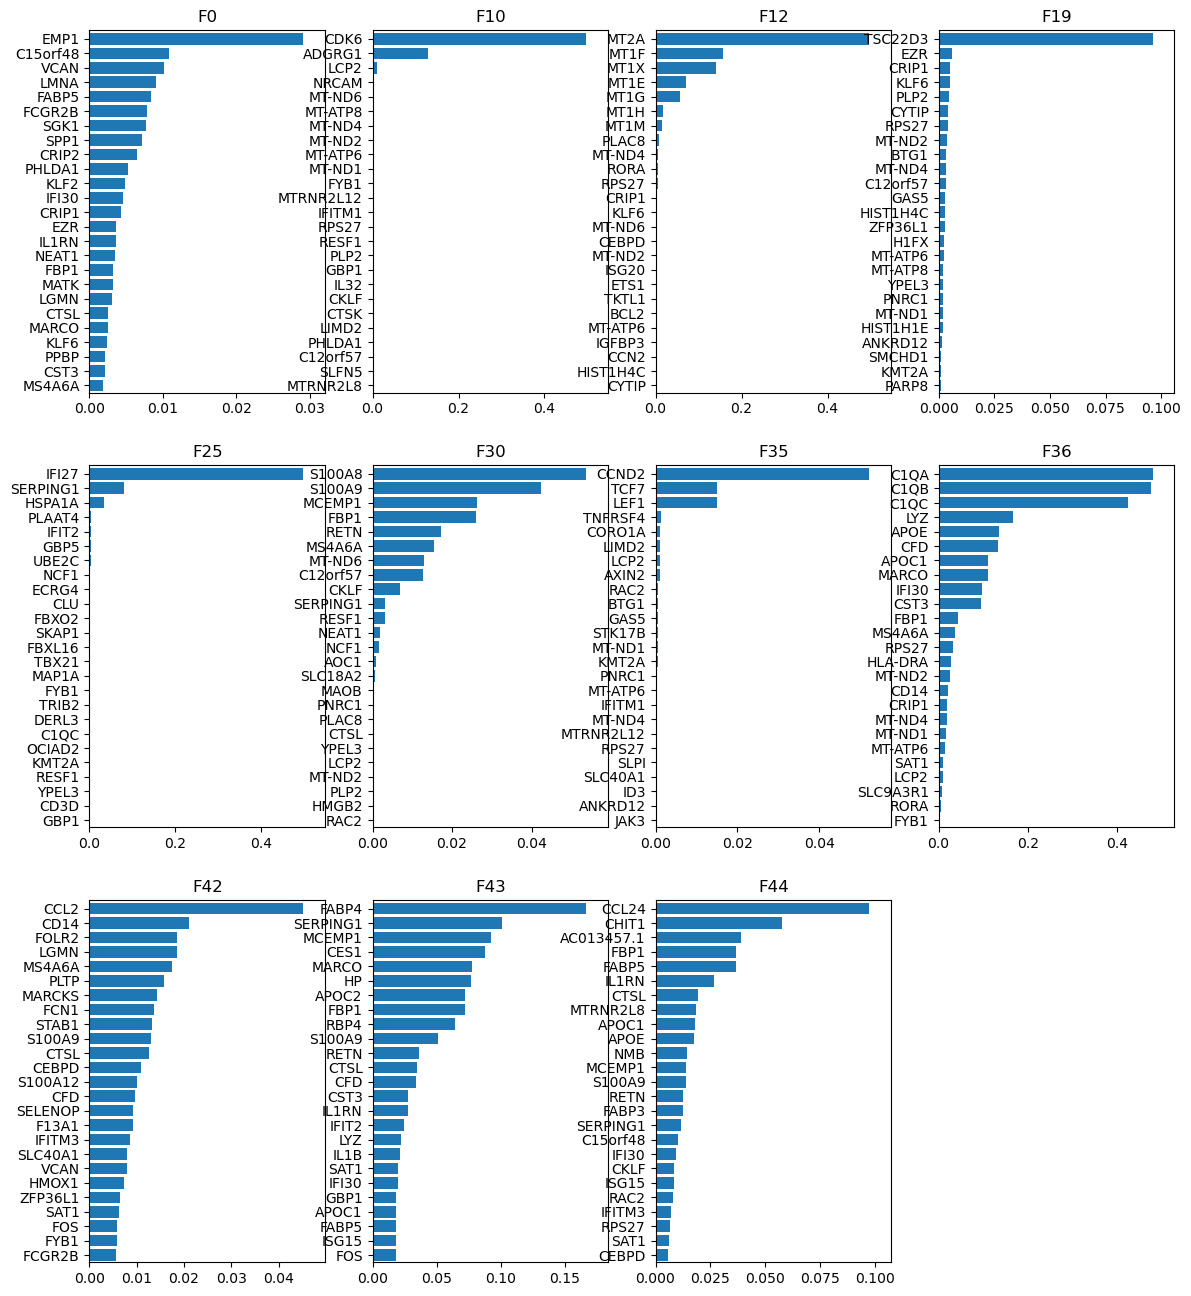

In [49]:
ngene = 25
pathways = np.sort(list(pd.unique(df_all_filt.Pathway)) + ['F25', 'F30', 'F35'])

nr = 3
nc = 4
fig, axs = plt.subplots(nr, nc, figsize = (14, 16))
for i in range(nr):
    for j in range(nc):
        ix = nc * i + j
        if ix < len(pathways):
            p = pathways[ix]
            w = pd.DataFrame(gene_weights[p]).sort_values(p, ascending = False)[0:ngene][::-1]
            axs[i, j].barh(w.index, w[p])
            axs[i, j].set_title(''.join(p.split('_')[0:2]))
            axs[i, j].set_xlim((0, 1.05 * axs[i, j].get_xlim()[1]))
            axs[i, j].set_ylim((-0.5, ngene - 0.4))
        else:
            axs[i, j].axis('off')
plt.show()

## Heatmap visualizing factors

In [50]:
all_scores = subject_scores.loc[subject_scores.cell_type == cell_types[0]].copy()
for ct in cell_types[1:]:
    all_scores = pd.concat([all_scores, subject_scores.loc[subject_scores.cell_type == ct].copy()])
all_scores = all_scores.reset_index(drop = True)

In [51]:
all_scores.cell_type = pd.Categorical(all_scores.cell_type)
cell_order = ['TRAM-1', 'TRAM-2', 'TRAM-3', 'TRAM-4', 'TRAM-5', 'TRAM-6', 'TRAM-7', 'Proliferating macrophages',
              'MoAM-1', 'MoAM-2', 'MoAM-3', 'MoAM-4', 'Perivascular macrophages', 'Monocytes-1', 'Monocytes-2',
              'CD4 T cells-1', 'CD4 T cells-2', 'CD8 T cells-1', 'CD8 T cells-2', 'CD8 T cells-3', 'Tregs',
              'gdT cells and NK cells', 'Proliferating T cells', 'DC1', 'DC2', 'Migratory DC', 'pDC',
              'Mast cells', 'B cells', 'Plasma cells']
all_scores.cell_type = all_scores.cell_type.cat.set_categories(cell_order, ordered = True)
all_scores = all_scores.sort_values('cell_type')

In [52]:
all_scores_sub = all_scores.drop(columns = ["Study_ID", "cell_type", "Status", "n_cell"]).fillna(0)
all_scores_sub.index = pd.Index(all_scores.cell_type)
all_scores_sub = all_scores_sub.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

/home/chp4225/.conda/envs/pasc-env/lib/python3.9/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


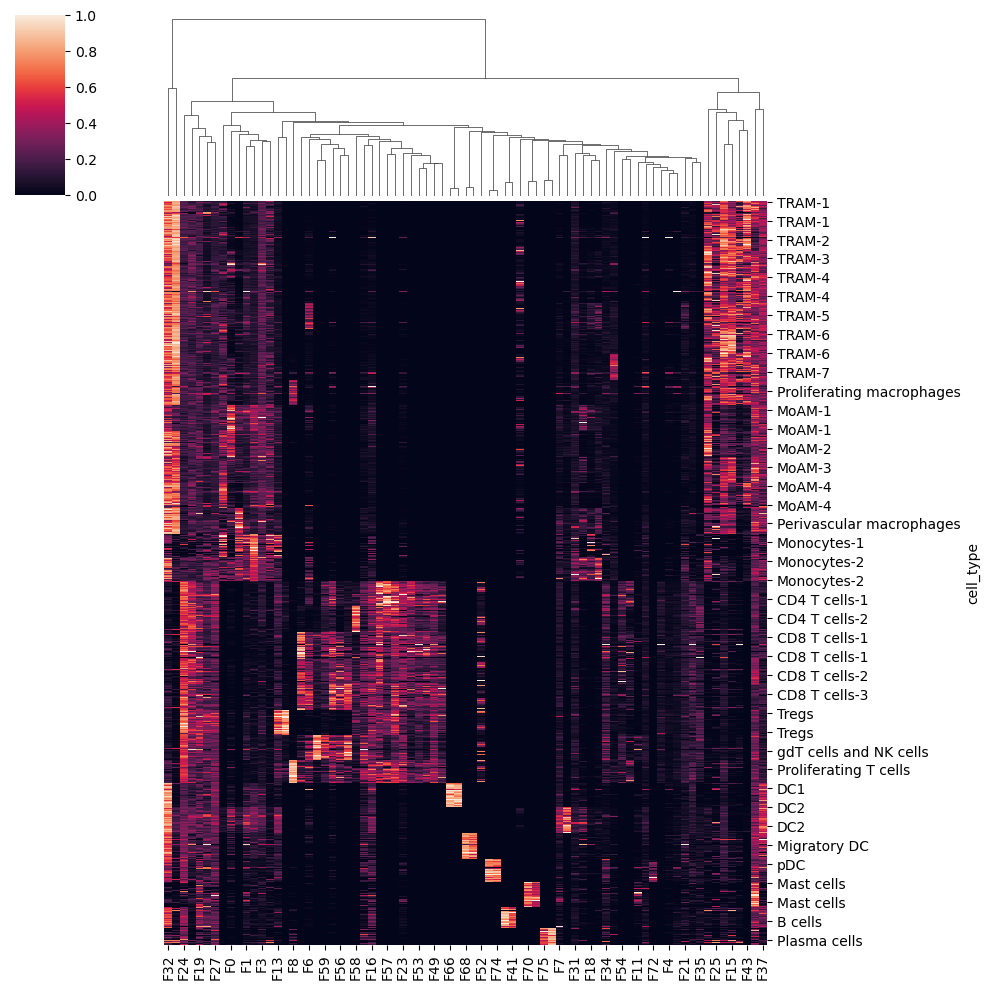

In [53]:
# Hierarchical clustering of factors
sorted_scores = all_scores_sub.copy()
g = sns.clustermap(sorted_scores, row_cluster = False, col_cluster = True)
col_linkage = g.dendrogram_col.linkage
col_order = g.dendrogram_col.reordered_ind
sorted_scores = sorted_scores.iloc[:, col_order[::-1]]

In [54]:
# Shorten names when space is needed
sorted_scores.index = sorted_scores.index.str.replace('Proliferating macrophages', 'Prolif. MP')
sorted_scores.index = sorted_scores.index.str.replace('Perivascular macrophages', 'Periv. MP')
sorted_scores.index = sorted_scores.index.str.replace('Proliferating T cells', 'Prolif. T')
sorted_scores.index = sorted_scores.index.str.replace('gdT cells and NK cells', 'gdT, NK')
sorted_scores.index = sorted_scores.index.str.replace('Migratory DC', 'Migr. DC')
sorted_scores.index = sorted_scores.index.str.replace('Mast cells', 'Mast')
sorted_scores.index = sorted_scores.index.str.replace('Plasma cells', 'Plas.')
sorted_scores.index = sorted_scores.index.str.replace('Monocytes', 'Mono')
sorted_scores.index = sorted_scores.index.str.replace('T cells', 'T')

In [55]:
# Create figure
fig = plt.figure(figsize = (30, 14))
gs = gridspec.GridSpec(1, 2, width_ratios = [0.4, 10], wspace = 0.035)
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

# Create heatmap
sns.heatmap(sorted_scores.T, cbar_kws = {"shrink": 0.3, "pad": 0.015}, yticklabels = 1,
            linecolor = 'black', ax = ax1)
ax1.set_xlabel('')
ax1.set_xticklabels([''] * len(ax1.get_xticklabels()))
ax1.tick_params(axis = 'x', which = 'both', bottom = False)
ax1.tick_params(axis = 'y', labelsize = 10)

# Create dendrogram
dendro = dendrogram(col_linkage, orientation = 'left', ax = ax0, above_threshold_color = 'gray',
                    color_threshold = 0)
ax0.set_xticks([])
ax0.set_yticks([])
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_visible(False)
ax0.spines['bottom'].set_visible(False)

cell_names = sorted_scores.index.unique().tolist()
palette = sns.color_palette("muted")
colors = []
for i in range(int(np.ceil(len(cell_names) / len(palette)))):
    colors += palette

lw = 1.2
sc = 0
ax0.set_ylim((ax0.get_ylim()[0], ax0.get_ylim()[1] + 12))
ax1.set_ylim((ax1.get_ylim()[0], ax1.get_ylim()[1] - lw))
offset = [3.3, 4.2, 3, 3, 3, 3, 3, 1.4, 2.5, 2.5, 2.4, 2.4, 1, 4.6, 4.6,
          2.8, 2.8, 2.8, 2.8, 2.8, 6.5, 3.2, 5.3, 9, 8.8, 2, 10, 8, 7.5, 13.5]
for i in range(len(cell_names)):
    nc = np.sum(sorted_scores.index == cell_names[i])
    ax1.add_patch(patches.Rectangle((sc, -lw), nc, lw, edgecolor = 'k', facecolor = colors[i]))
    ax1.text(sc + nc - 30 + offset[i], -0.28, cell_names[i], size = 9.5)
    sc += nc

plt.savefig(f"{data_dir}/figures/fig_s4/fig_s4_c_new.pdf", bbox_inches = 'tight', transparent = True)
plt.close()

## Resolving vs. Non-resolving

In [56]:
ct_data = pd.read_csv(f"{data_dir}/deidentified_data/deidentified_ct_data_all.csv", index_col = 0)
resolving = ct_data.index[ct_data["Normal (diff)"] > 0].to_list()
non_resolving = ct_data.index[ct_data["Normal (diff)"] < 0].to_list()

resolving = ['RPRA01', 'RPRA02', 'RPRA03', 'RPRA04', 'RPRA07', 'RPRA08', 'RPRA09', 'RPRA10', 'RPRA14',
             'RPRA15', 'RPRA16', 'RPRA19', 'RPRA21', 'RPRA22', 'RPRA25', 'RPRA26', 'RPRA27', 'RPRA30',
             'RPRA31', 'RPRA32', 'RPRA33', 'RPRA29']
non_resolving = ['RPRA05', 'RPRA06', 'RPRA11', 'RPRA23', 'RPRA24', 'RPRA34', 'RPRA17']

In [57]:
def get_scores(cell_type, subjects):
    # Subset to cell type and specified subjects
    subj_mask = [x in subjects for x in subject_scores.Study_ID]
    scores = subject_scores.loc[(subject_scores.cell_type == cell_type) & subj_mask].copy()
    scores = scores.set_index("Study_ID")
    # Filter subjects
    total_cells = np.sum(adata.obs.cell_type == cell_type)
    cutoff = math.floor(0.01 * total_cells)
    scores = scores[scores.n_cell > max(40, cutoff)]
    # Remove unused factors
    scores = scores.loc[:, scores.sum(axis = 0) != 0]
    return scores

In [58]:
all_res = pd.DataFrame([], columns = ['cell_type', 'factor', 'n1', 'n2', 'pval', 'padj'])
for cell_type in cell_types:
    resolving_scores = get_scores(cell_type, resolving)
    non_resolving_scores = get_scores(cell_type, non_resolving)
    n1 = resolving_scores.shape[0]
    n2 = non_resolving_scores.shape[0]
    # Require 3 subjects per condition for testing
    if (n1 >= 3) and (n2 >= 3):
        res = []
        factors = np.intersect1d(resolving_scores.columns[3:], non_resolving_scores.columns[3:])
        for factor in factors:
            p = mannwhitneyu(resolving_scores[factor], non_resolving_scores[factor]).pvalue
            res.append([cell_type, factor, n1, n2, p])
        res = pd.DataFrame(res, columns = ['cell_type', 'factor', 'n1', 'n2', 'pval'])
        _, res['padj'] = fdrcorrection(res.pval, alpha = 0.05, method = 'p')
    all_res = pd.concat([all_res, res], ignore_index = True)

In [59]:
all_res = all_res.sort_values('padj').reset_index(drop = True)
all_res.to_csv(f"{data_dir}/01BAL/spectra/resolving_vs_nonresolving.csv")

In [60]:
all_res[all_res.padj <= 0.05]

,cell_type,factor,n1,n2,pval,padj


## Correlation of factors with CT data

In [ ]:
ct_data = pd.read_csv(f"{data_dir}/deidentified_data/deidentified_ct_scan_1_data.csv", index_col = 0)
ct_features = ['Normal', 'Fibrotic', 'Inflammatory', 'Nodularity']

In [ ]:
rpra_scores = subject_scores.loc[subject_scores.Status == "RPRA"].reset_index(drop = True)

In [ ]:
rpra_scores.to_csv(f"{data_dir}/01BAL/spectra/rpra_scores.csv")

In [ ]:
### Run as Quest job ###

def get_scores(cell_type):
    # Subset to cell type
    scores = rpra_scores.loc[rpra_scores.cell_type == cell_type].copy()
    scores = scores.set_index("Study_ID")
    # Add CT data
    scores = pd.concat([scores, ct_data.loc[scores.index]], axis = 1)
    # Filter subjects
    total_cells = np.sum(adata.obs.cell_type == cell_type)
    cutoff = math.floor(0.01 * total_cells)
    scores = scores[scores.n_cell > max(40, cutoff)]
    # Remove unused factors
    scores = scores.loc[:, scores.sum(axis = 0) != 0]
    return scores

def spearman_corr(x, y):
    rx = np.argsort(np.argsort(np.array(x)))
    ry = np.argsort(np.argsort(np.array(y)))
    mean_rx = np.mean(rx)
    mean_ry = np.mean(ry)
    cov_rxy = np.sum((rx - mean_rx) * (ry - mean_ry))
    sigma_rx = np.sqrt(np.sum((rx - mean_rx) ** 2))
    sigma_ry = np.sqrt(np.sum((ry - mean_ry) ** 2))
    return cov_rxy / (sigma_rx * sigma_ry)

def corr_test(cell_type, ct_feature, factor):
    scores = get_scores(cell_type)
    if factor not in scores.columns:
        return None
    factor_scores = scores[pw]
    ct_vals = scores[ct_feature]
    test = permutation_test(
        (ct_vals, factor_scores),
        spearman_corr,
        permutation_type = 'pairings',
        n_resamples = 1e4
    )
    return pd.DataFrame([[cell_type, ct_feature, factor, test.statistic, test.pvalue]],
                        columns = ['cell_type', 'ct_feature', 'factor', 'corr', 'pval'])

res = []
nworker = 64
all_factors = rpra_scores.columns[4:].to_list()
with concurrent.futures.ThreadPoolExecutor(max_workers = nworker) as exc:
    futures = []
    for x in cell_types_to_run:
        for y in ct_features:
            for z in all_factors:
                futures.append(exc.submit(corr_test, x, y, z))
    for f in concurrent.futures.as_completed(futures):
        r = f.result()
        print(f"Finished {r.cell_type[0]}, {r.ct_feature[0]}, {r.factor[0]}", flush = True)
        res.append(r)
df_all = pd.concat(res)

adj_res = []
for cell_type in cell_types_to_run:
    df_all_sub = df_all[df_all.cell_type == cell_types_to_run[0]].copy()
    _, df_all_sub['padj'] = fdrcorrection(df_all_sub.pval, alpha = 0.05, method = 'p')
    adj_res.append(df_all_sub)
df_adj = pd.concat(adj_res).reset_index(drop = True)
df_adj.to_csv(f"{data_dir}/01BAL/spectra/spectra_ct_corr.csv")

In [ ]:
df_adj = pd.read_csv(f"{data_dir}/01BAL/spectra/spectra_ct_corr.csv", index_col = 0)
rpra_scores = pd.read_csv(f"{data_dir}/01BAL/spectra/rpra_scores.csv", index_col = 0)

In [ ]:
df_adj.sort_values("padj").head()

In [ ]:
df_adj_filt = df_adj.loc[df_adj.padj <= 0.05].sort_values("padj").reset_index(drop = True)
df_adj_filt

In [ ]:
df_adj_filt = df_adj_filt.sort_values("cell_type").reset_index(drop = True)
df_adj_filt

In [ ]:
def get_scores(cell_type):
    # Subset to cell type
    scores = rpra_scores.loc[rpra_scores.cell_type == cell_type].copy()
    scores = scores.set_index("Study_ID")
    # Add CT data
    scores = pd.concat([scores, ct_data.loc[scores.index]], axis = 1)
    # Filter subjects
    total_cells = np.sum(adata.obs.cell_type == cell_type)
    cutoff = math.floor(0.01 * total_cells)
    scores = scores[scores.n_cell > max(40, cutoff)]
    # Remove unused factors
    scores = scores.loc[:, scores.sum(axis = 0) != 0]
    return scores

In [ ]:
# Correlation plots
nrow = 2
ncol = 3
fig, axs = plt.subplots(nrow, ncol, figsize = (16, 9.5))
fig.subplots_adjust(hspace = 0.24)
for i in range(nrow):
    for j in range(ncol):
        ix = i * ncol + j
        cell_type = df_adj_filt['cell_type'][ix]
        ct = df_adj_filt['ct_feature'][ix]
        pw = df_adj_filt['factor'][ix]
        cr = df_adj_filt['corr'][ix]
        q = df_adj_filt['padj'][ix]
        scores_ct = get_scores(cell_type)

        axs[i, j].scatter(scores_ct[ct], scores_ct[pw], color = 'k')
        axs[i, j].set_title(cell_type, fontsize = 13)
        axs[i, j].set_xlabel(ct, fontsize = 13)
        axs[i, j].set_ylabel(pw, fontsize = 13)
        axs[i, j].ticklabel_format(style = 'sci', scilimits = [-2, 6])

        cx = 0.03 if cr > 0 else 0.76
        axs[i, j].text(cx, 0.95, f'$\\rho={cr:.3f}$', transform = axs[i, j].transAxes, fontsize = 10)
        axs[i, j].text(cx, 0.895, f'$q={q:.3f}$', transform = axs[i, j].transAxes, fontsize = 10)

plt.savefig(f"{data_dir}/figures/fig_4/spectra_ct_corr_plots.pdf", bbox_inches = 'tight', transparent = True)
plt.close()